## Load packages

In [3]:
import pandas as pd
import numpy as np

from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split

from transparentai.datasets import load_iris
from transparentai.models import ClassificationModel

In [4]:
adult = pd.read_csv('../_data/adult_prep.csv')
iris = load_iris()

In [5]:
adult.head(2)

,age,educational-num,capital-gain,capital-loss,hours-per-week,workclass=?,workclass=Federal-gov,workclass=Local-gov,workclass=Never-worked,workclass=Private,...,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income
0,0.109589,0.400000,0.0,0.0,0.397959,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,<=50K
1,0.287671,0.533333,0.0,0.0,0.500000,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,<=50K


In [6]:
iris.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),iris plant
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa


In [7]:
target = 'income'
target_value = {'>50K':1, '<=50K':0}
adult[target] = adult[target].replace(target_value)

In [8]:
X, y = adult.drop(columns=target), adult[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Overall model performance

,accuracy,f1,precision,recall,roc_auc
score,0.851967,0.851967,0.851967,0.851967,[0.894628756441585]


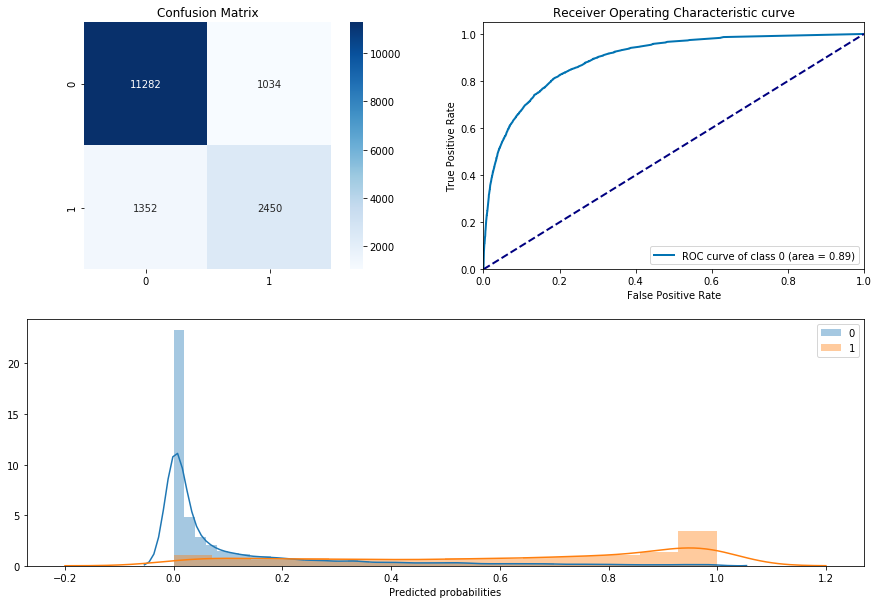

## Proba threshold comparison for accuracy, f1 score, precision & recall

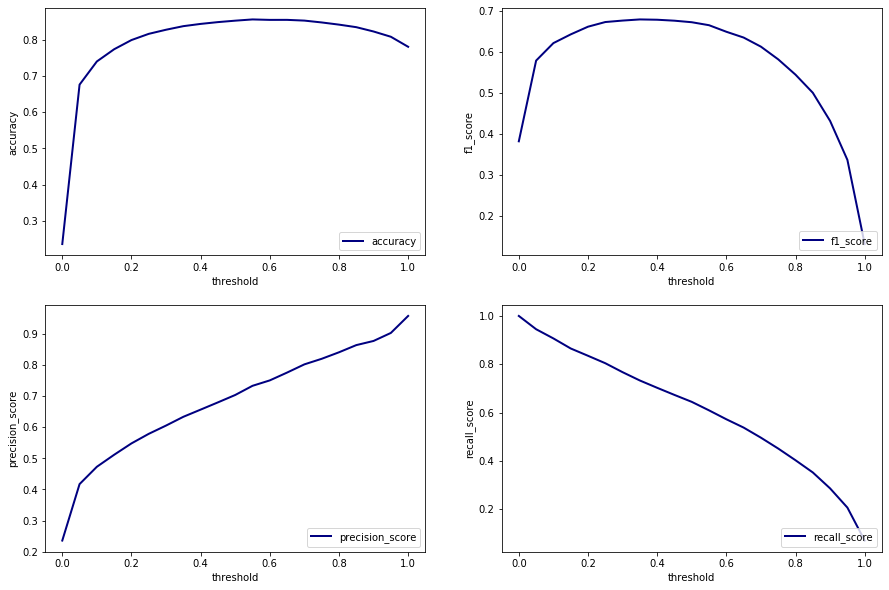

In [10]:
model = ClassificationModel(model=clf)
model.compute_scores(X=X_test, y=y_test, threshold=0.5)
model.plot_scores()
model.plot_threshold()

In [11]:
target = 'iris plant'
target_value = {'virginica':0, 'versicolor':1, 'setosa':2}
iris[target] = iris[target].replace(target_value)

X, y = iris.drop(columns=target), iris[target]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.33, random_state=42)
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(random_state=0)

clf2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Overall model performance

,accuracy,f1,precision,recall,roc_auc
score,0.98,0.98,0.98,0.98,"[1.0, 1.0, 1.0]"


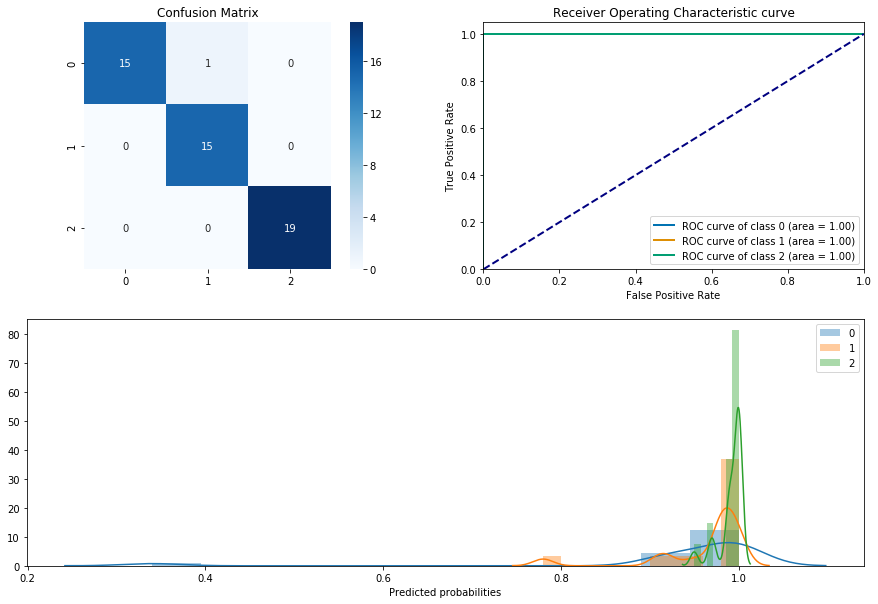

In [13]:
model = ClassificationModel(model=clf2)
model.compute_scores(X=X_test2, y=y_test2)
model.plot_scores()

In [2]:

import matplotlib.pyplot as plt

plt.xlabel

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, **kwargs)>

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize

class ClassificationModel():
    """    
    Class to inspect a classification model based on a model which has a `predict` and 
    `predict_proba` functions.
    It could help you to explore your model performance and validate or not your model.
    And you can also find out model bias with `plot_bias` function.
    """
    
    def __init__(self, model):
        """
        Parameters
        ----------
        model:
            a classifier model that have a `predict` and `predict_proba` functions
        """
        self.model = model
        self.scores = None
        self.threshold_df = None
        
    def compute_scores(self, X, y, threshold=0.5):
        """
        Compute all predictions, probalities and scores
        if it's binary classifier you can custom the probability threshold
        
        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
            feature samples
        y: array-like of shape (n_samples,) or (n_samples, n_outputs)
            true labels for X.
        threshold: float (optional) default=0.5
            only for binary classifier, custome threshold probability 
            for the prediction
        """
        self.X = X
        self.y_true = y
        self.n_classes = len(list(set(y)))
        
        self.y_proba = self.model.predict_proba(X)
        
        if  self.n_classes == 2:
            self.y_preds = (self.y_proba[:, 1] >= threshold).astype(int)
            self.compute_threshold(X=X, y=y)
        else:
            self.y_preds = self.model.predict(X)
        
        self.scores()
    
    def scores(self):
        """
        Compute classification metrics scores based on skearn Model evaluation_
        Current metrics : accuracy, confusion_matrix, f1_score, precision, recall & roc_auc
        
        .. _skearn Model evaluation: https://scikit-learn.org/0.15/modules/model_evaluation.html
        """
        scores = {}
        scores['accuracy'] = accuracy_score(self.y_true, self.y_preds)
        scores['confusion_matrix'] = confusion_matrix(self.y_true, self.y_preds)
        
        average = 'micro'      
        scores['f1'] = f1_score(self.y_true, self.y_preds, average=average)
        scores['precision'] = precision_score(self.y_true, self.y_preds, average=average)
        scores['recall'] = recall_score(self.y_true, self.y_preds, average=average)
        
        roc_auc, roc_curves = dict(), dict()        
        if self.n_classes > 2:
            y = label_binarize(self.y_true, classes=list(range(0, self.n_classes)))
            for i in range(0, self.n_classes):
                roc_auc[i] = roc_auc_score(y[:,i], self.y_proba[:,i])
                roc_curves[i] = roc_curve(y[:,i], self.y_proba[:,i])
        else:
            roc_auc[0] = roc_auc_score(self.y_true, self.y_proba[:,1])
            roc_curves[0] = roc_curve(self.y_true, self.y_proba[:,1])
            
        scores['roc_auc'] = [v for k,v in roc_auc.items()]
        scores['roc_curve'] = [v for k,v in roc_curves.items()]
            
        self.scores = scores
        
    def display_scores(self):
        """
        Display current scores computed by `compute_scores` function.
        """
        if self.scores is None:
            raise ValueError('Use compute_scores() function first.')
        
        scores_to_display = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
            
        scores = {k: v for k, v in self.scores.items() if k in scores_to_display}
        scores = pd.Series(scores).to_frame().T
        scores.index = ['score']
        
        display(scores)
        
    def plot_scores(self):
        """
        Display different charts for all the metrics : 
        - a dataframe for accuracy, f1, precision, recall & roc_auc
        - confusion matrix
        - ROC curve 
        - Probalities distribution
        
        Raises
        ------
        """
        if self.scores is None:
            raise ValueError('Use compute_scores() function first.')
            
        display(Markdown('### Overall model performance'))
        self.display_scores()
        
        plot_classification_scores(self.scores, self.y_true, self.y_proba)
        
        
    def compute_threshold(self, X, y, start=0, end=1, step=0.05):
        """
        Compute all predictions, probalities and scores
        if it's binary classifier you can custom the probability threshold
        
        Parameters
        ----------
        X: array-like of shape (n_samples, n_features)
            feature samples
        y: array-like of shape (n_samples,) or (n_samples, n_outputs)
            true labels for X.
        start: int, default=0
            minimum probability to compare 
            (should be between 0 and 1 and less than end value)
        end: int, default=1
            minimum probability to compare 
            (should be between 0 and 1 and greater than start value)
        step: float, default=0.05
            value between each threshold steps
        
        Raises
        ------
        """
        if self.n_classes > 2:
            raise Exception('This function can be only called for binary classification.')   
        if start > end:
            raise ValueError('start has to be smaller than end') 
        if (start < 0) or (start > 1):
            raise ValueError('start has to be between 0 and 1') 
        if (end < 0) or (end > 1):
            raise ValueError('end has to be between 0 and 1') 
        
        threshold = start
        threshold_df = pd.DataFrame()
        
        proba = self.model.predict_proba(X)
        
        while threshold <= end:
            threshold = round(threshold,2)
            preds = (proba[:, 1] >= threshold).astype(int)

            threshold_df[threshold] = preds
            threshold += step
            
        self.threshold_df = threshold_df
        
    def plot_threshold(self):
        """
        Display curves for four metrics by threshold on x axis :
        - accuracy
        - f1 score
        - precision
        - recall
        
        Raises
        ------
        """
        if self.threshold_df is None:
            raise ValueError('Use compute_threshold() function first.')
            
        display(Markdown('## Proba threshold comparison for accuracy, f1 score, precision & recall'))
        
        compare_threshold_predictions(self.threshold_df, self.y_true)

### Overall model performance

,accuracy,f1,precision,recall,roc_auc
score,0.851967,0.851967,0.851967,0.851967,[0.894628756441585]


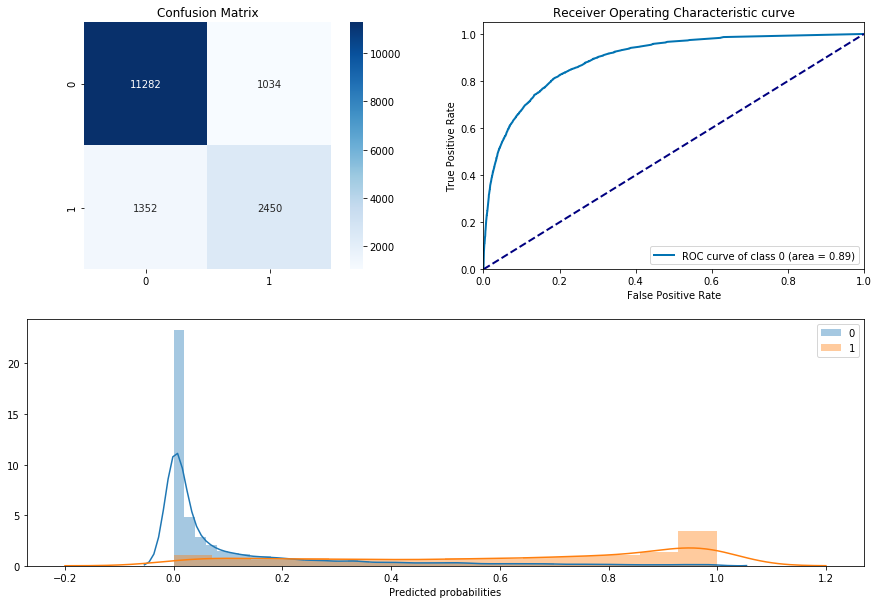

## Proba threshold comparison for accuracy, f1 score, precision & recall

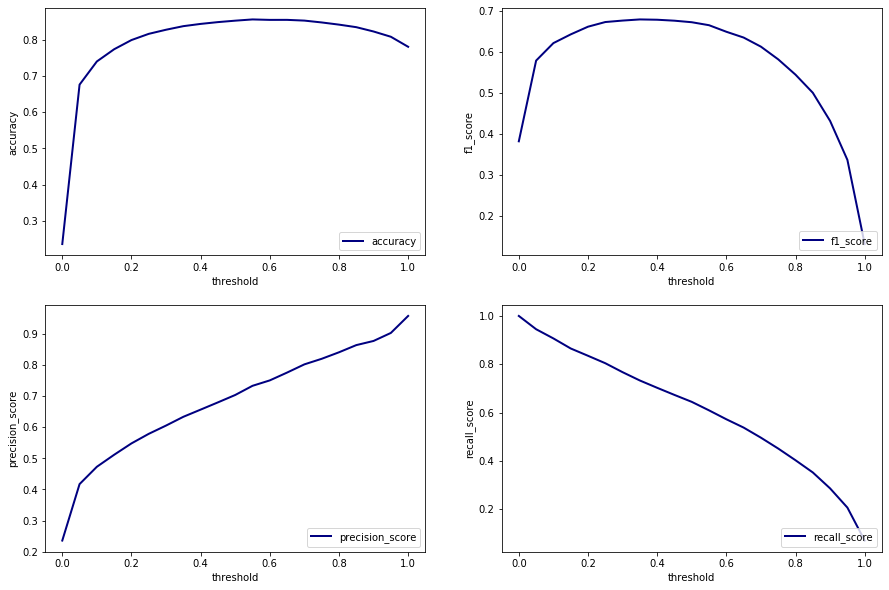

In [9]:
iris['iris plant'].value_counts()

virginica     50
versicolor    50
setosa        50
Name: iris plant, dtype: int64

In [10]:
target = 'iris plant'
target_value = {'virginica':0, 'versicolor':1, 'setosa':2}
iris[target] = iris[target].replace(target_value)

In [11]:
target = 'iris plant'
target_value = {'virginica':0, 'versicolor':1, 'setosa':2}
iris[target] = iris[target].replace(target_value)
X, y = iris.drop(columns=target), iris[target]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.33, random_state=42)
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(random_state=0)

clf2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
def plot_classification_scores(scores, y_true, y_proba):
    """
    Display different charts for all the metrics : 
    - a dataframe for accuracy, f1, precision, recall & roc_auc
    - confusion matrix
    - ROC curve 
    - Probalities distribution
    
    Parameters
    ----------
    scores: pd.DataFrame
        scores dataframe attribute of a ClassificationModel object
    y_true: array-like
        true labels
    y_proba: array
        Target scores, can either be probability estimates of the positive class, 
        confidence values, or binary decisions.
    """
    n_classes = len(y_proba[0])
    fig = plt.figure(figsize=(15, 10))
    
    n_rows = 1 + n_classes
    ax = plt.subplot(int(f'221'))
    plot_confusion_matrix(matrix=scores['confusion_matrix'])
    
    ax = plt.subplot(int(f'222'))
    plot_roc_curve(roc_curve=scores['roc_curve'], roc_auc=scores['roc_auc'], n_classes=n_classes)
    
    ax = plt.subplot(int(f'212'))
    plot_class_distribution(y_true=y_true, y_proba=y_proba, n_classes=n_classes)
    
    plt.show()
        
def plot_confusion_matrix(matrix):
    """
    Show confustion matrix.
    
    Parameters
    ----------
    matrix: array
        confusion_matrix metrics result
    """
    sns.heatmap(matrix, 
                cmap='Blues',
                square=True,
                fmt='d', 
                annot=True)
    plt.title('Confusion Matrix')
    
    
def plot_roc_curve(roc_curve, roc_auc, n_classes):
    """
    Show a roc curve plot with roc_auc score on legend.
    
    Parameters
    ----------
    roc_curve: array
        roc_curve metrics result for each classes
    roc_auc: array
        roc_auc metrics result for each classes        
    n_classes: int
        Number of classes
    """
    fpr, tpr = dict(), dict()
    
    for i in range(0, len(roc_curve)):
        fpr[i] = roc_curve[i][0]
        tpr[i] = roc_curve[i][1]
    lw = 2

    colors = sns.color_palette("colorblind", n_classes)
    for i, color in zip(range(n_classes), colors):        
        n = 1 if n_classes == 1 else i
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(n, roc_auc[i]))
        if n_classes <= 2:
            break

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    
def plot_class_distribution(y_true, y_proba, n_classes):
    """
    Show class distribution using seaborn `distplot`_ function.
    if n_classes is 2 then display probability for class 1 only.
    So class 0 probalities should tend towards 0 and class 1 towards 1.
        
    else it displays all probabilities for current class so all 
    probabilities should tend towards 1.
    
    .. _displot: https://seaborn.pydata.org/generated/seaborn.distplot.html
    
    Parameters
    ----------
    y_true: array-like
        true labels
    y_proba: array
        Target scores, can either be probability estimates of the positive class, 
        confidence values, or binary decisions.
    n_classes: int
        Number of classes
    """    
    df = pd.DataFrame()
    df['y_true'] = y_true
    for i in range(0, n_classes):
        df[i] = [v[i] for v in y_proba]
        
    if n_classes == 2:
        df[0] = df[1] 
      
    colors = sns.color_palette("colorblind", n_classes)
    for i in range(0, n_classes):
        sns.distplot(df[df['y_true'] == i][i], label=i)
        plt.legend(loc=0)
    
    plt.xlabel('Predicted probabilities')
    

def plot_curve(df, var):
    """
    Plot one curve based on a dataframe with a specific variable
    
    Parameters
    ----------
    df: pd.DataFrame
        Dataframe to inspect
    var: str
        Variable name inside dataframe
    """    
    lw = 2
    ax.plot(df.index, df[var], color='navy', lw=lw, label=var)
    ax.set_xlabel('threshold')
    ax.set_ylabel(var)
    ax.legend(loc="lower right")
    
def compare_threshold_predictions(threshold_df, y_true):
    """
    Display curves for four metrics by threshold on x axis :
    - accuracy
    - f1 score
    - precision
    - recall
    
    Parameters
    ----------
    threshold_df: pd.DataFrame
        dataframe with different threshold on columns
    y_true:
        true labels        
    """
    df = list()
    for threshold in threshold_df:            
        accuracy = accuracy_score(y_true, threshold_df[threshold])
        f1 = f1_score(y_true, threshold_df[threshold])
        precision = precision_score(y_true, threshold_df[threshold])
        recall = recall_score(y_true, threshold_df[threshold])
        df.append([accuracy, f1, precision, recall])

    df = pd.DataFrame(df, 
                      columns=['accuracy', 'f1_score', 'precision_score', 'recall_score'], 
                      index=threshold_df.columns
                     )

    scores = df.columns
    fig = plt.figure(figsize=(15, 10))

    for i in range(0,4):
        ax = fig.add_subplot(2, 2, i+1)
        plot_curve(df=df, var=scores[i])
        
    plt.show()